In [1]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
# How to enable Colab GPUs https://colab.research.google.com/notebooks/gpu.ipynb
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
        print('Found GPU at: {}'.format(device_name))

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, BatchNormalization, GlobalAveragePooling1D, Flatten, Reshape
from keras.optimizers import Adam, Adadelta

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

env: PYTHONHASHSEED=0


# Keras Neural Networks for Weather Time Series Nowcasts

Building neural networks with [keras](https://keras.io/) for time series analysis of Cambridge UK weather data.


## Import Data

Data has been cleaned but may still have issues.  See the 
[cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning)
in the 
[Cambridge Temperature Model](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
repository for details.

The `y` variable is temperature * 10.  I'm primarily interested in short term temperature forecasts (less than 2 hours) but forecasts over 24 hours are also interesting.

In [2]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/data/CamUKWeather.csv?raw=true"
else:
    data_loc = "../data/CamUKWeather.csv"
df = pd.read_csv(data_loc, parse_dates = True)
print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
df

Shape:
(192885, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192885 entries, 0 to 192884
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ds                 192885 non-null  object
 1   year               192885 non-null  int64 
 2   doy                192885 non-null  int64 
 3   time               192885 non-null  object
 4   y                  192885 non-null  int64 
 5   humidity           192885 non-null  int64 
 6   dew.point          192885 non-null  int64 
 7   pressure           192885 non-null  int64 
 8   wind.speed.mean    192885 non-null  int64 
 9   wind.bearing.mean  192885 non-null  int64 
 10  wind.speed.max     192885 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 16.2+ MB
None

Summary stats:


,year,doy,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
count,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000
mean,2013.895803,186.882298,101.096819,79.239951,62.135174,1014.404153,44.588148,196.223423,117.140369
std,3.283992,106.486420,64.465602,16.908724,51.016879,11.823922,40.025546,82.458390,80.116199
min,2008.000000,1.000000,-138.000000,25.000000,-143.000000,963.000000,0.000000,0.000000,0.000000
25%,2011.000000,94.000000,52.000000,69.000000,25.000000,1008.000000,12.000000,135.000000,60.000000
50%,2014.000000,191.000000,100.000000,83.000000,64.000000,1016.000000,35.000000,225.000000,100.000000
75%,2017.000000,280.000000,145.000000,92.000000,100.000000,1023.000000,67.000000,270.000000,160.000000
max,2020.000000,366.000000,361.000000,100.000000,216.000000,1048.000000,291.000000,315.000000,580.000000



Raw data:


,ds,year,doy,time,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
0,2008-08-01 08:30:00,2008,214,09:30:00,186,69,128,1010,123,180,280
1,2008-08-01 09:00:00,2008,214,10:00:00,191,70,135,1010,137,180,260
2,2008-08-01 09:30:00,2008,214,10:30:00,195,68,134,1010,133,180,260
3,2008-08-01 10:00:00,2008,214,11:00:00,200,68,139,1010,129,180,240
4,2008-08-01 10:30:00,2008,214,11:30:00,213,61,135,1010,145,180,260
...,...,...,...,...,...,...,...,...,...,...,...
192880,2020-01-16 00:00:00,2020,16,00:00:00,40,78,5,1017,45,180,100
192881,2020-01-16 00:30:00,2020,16,00:30:00,36,86,15,1018,25,180,120
192882,2020-01-16 01:00:00,2020,16,01:00:00,36,85,13,1018,28,180,80
192883,2020-01-16 01:30:00,2020,16,01:30:00,36,82,8,1018,17,180,80


Will need to take care not to end up with more neural network parameters than data!

---

## Feature Engineering

The data must be reformatted before model building.

The following steps are necessary:
 * Wind direction and speed transformation
 * Time conversion
 * Split data
 * Normalise data
 * Window data
   * **TODO** Handle missing data
   * Quite a bit of missing data
   * Limit windowed data to consecutive observations


### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is categorised at 45 degree increments, 
i.e. 0, 45, 90, 135, 180, 225, 270, 315.  Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

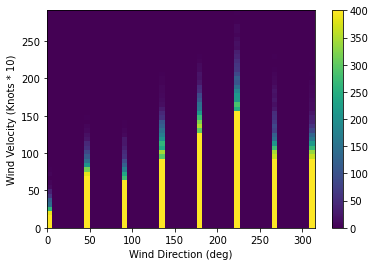

In [3]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction (deg)')
plt.ylabel('Wind Velocity (Knots * 10)');

Convert wind direction and speed to _x_ and _y_ vectors, so the model can more easily interpret them.

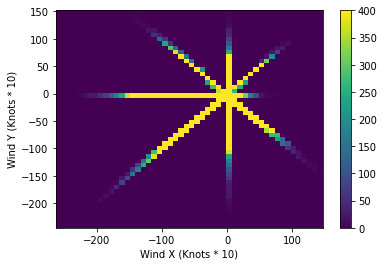

In [4]:
wv = df['wind.speed.mean']
max_wv = df['wind.speed.max']

# Convert to radians.
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components.
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max.wind.x'] = max_wv * np.cos(wd_rad)
df['max.wind.y'] = max_wv * np.sin(wd_rad)

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X (Knots * 10)')
plt.ylabel('Wind Y (Knots * 10)');

Better, but not ideal.  Some data augmentation with a method like 
[mixup](https://arxiv.org/abs/1710.09412) may be beneficial.


### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos`.

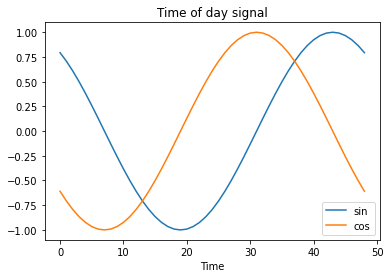

In [5]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[:49])
plt.plot(np.array(df['day.cos'])[:49])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

# plt.plot(np.array(df['year.sin'])[:17532])
# plt.plot(np.array(df['year.cos'])[:17532])
# plt.xlabel('Time')
# plt.title('Time of year signal');

### Split data

Use a (70%, 20%, 10%) split for the training, validation, and test sets.

In [6]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
             'day.sin', 'day.cos', 'year.sin', 'year.cos']
del_cols = ['ds', 'year', 'doy', 'time', 'max.wind.x', 'max.wind.y',
            'wind.bearing.mean', 'wind.speed.mean', 'wind.speed.max']
df_orig  = df
df.drop(del_cols, axis = 1, inplace = True)

n = len(df)
train_df = df[0:int(n * 0.7)]
valid_df = df[int(n * 0.7):int(n * 0.9)]
test_df  = df[int(n * 0.9):]

print("df.drop shape: ", df.shape)
print("train shape: ", train_df.shape)
print("valid shape: ", valid_df.shape)
print("test shape:  ",  test_df.shape)

df.drop shape:  (192885, 10)
train shape:  (135019, 10)
valid shape:  (38577, 10)
test shape:   (19289, 10)


### Normalise data

Features should be scaled before neural network training.  Arguably, scaling should be done using moving averages to avoid accessing future values.  
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) 
normalisation will be used.

Plot [violin plot](https://en.wikipedia.org/wiki/Violin_plot) 
to see distribution of features.

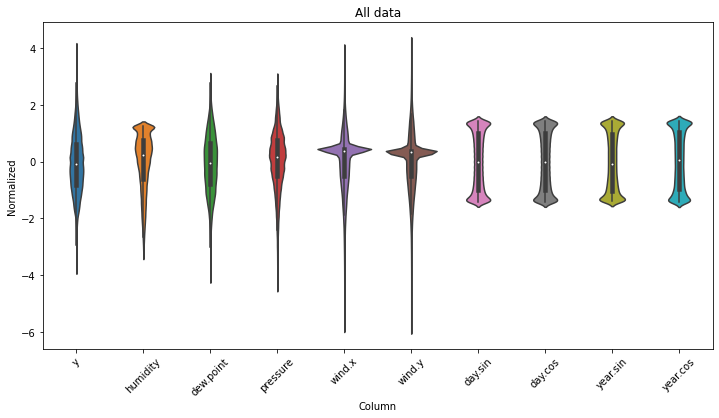

In [7]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df  = (test_df  - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 45)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.


### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing)
function:
 * sequence_length: 
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride: 
   * Period between successive output sequences.  For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
   * s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size: 
   * Number of samples in each batch
 * shuffle: 
   * Shuffle output samples, or use chronological order
 
Initial values used:
 * sequence_length (aka lags): 4
 * steps ahead (what to forecast): 1 and separately 4
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: True
 
The lags, batch_size and shuffle values may be optimised later.

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
 
Stride is used to specify offset + steps-ahead.  Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

First, check results are as expected for single batch with `shuffle = False`.
Then, process all training data with `shuffle = True`.

In [9]:
def make_dataset(data, y_cols, lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False):    
    assert stride >= steps_ahead

    total_window_size = lags + stride
    
    data_np = np.array(data, dtype = np.float32)    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
           data    = data_np,
           targets = None,
           sequence_length = total_window_size,
           sequence_stride = 1,
           shuffle    = shuffle,
           batch_size = bs)
            
    col_indices = {name: i for i, name in enumerate(data.columns)}    
    X_slice = slice(0, lags)
    y_start = total_window_size - steps_ahead
    y_slice = slice(y_start, None)

    
    def split_window(features):   
        X = features[:, X_slice, :]
        y = features[:, y_slice, :]

        X = tf.stack(
            [X[:, :, col_indices[name]] for name in data.columns],
            axis = -1)    
        y = tf.stack(
            [y[:, :, col_indices[name]] for name in y_cols],
            axis = -1)

        # Slicing doesn't preserve static shape information, so set the shapes manually.
        # This way the `tf.data.Datasets` are easier to inspect.
        X.set_shape([None, lags,        None])
        y.set_shape([None, steps_ahead, None])

        return X, y

    
    ds = ds.map(split_window)
        
    return ds


def make_datasets(train, valid, test, 
                  y_cols = 'y', lags = 1, steps_ahead = 1, 
                  stride = 1, bs = 32, shuffle = False):
    ds_train = make_dataset(train, y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    ds_valid = make_dataset(valid, y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    ds_test  = make_dataset(test,  y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    
    return ds_train, ds_valid, ds_test


def dataset_sanity_checks(data, name):
    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0])
    

# Single step-ahead
ds_train_1l_1s, ds_valid_1l_1s, ds_test_1l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 1, shuffle = False, bs = 16)
ds_train_4l_1s, ds_valid_4l_1s, ds_test_4l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 4, shuffle = False, bs = 16)
ds_train_8l_1s, ds_valid_8l_1s, ds_test_8l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 8, shuffle = False, bs = 16)
ds_train_16l_1s, ds_valid_16l_1s, ds_test_16l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 16, shuffle = False, bs = 16)
ds_train_24l_1s, ds_valid_24l_1s, ds_test_24l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 24, shuffle = False, bs = 16)
ds_train_32l_1s, ds_valid_32l_1s, ds_test_32l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 32, shuffle = False, bs = 16)
ds_train_40l_1s, ds_valid_40l_1s, ds_test_40l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 40, shuffle = False, bs = 16)
ds_train_48l_1s, ds_valid_48l_1s, ds_test_48l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 48, shuffle = False, bs = 16)
dataset_sanity_checks(ds_train_4l_1s, '4l 1s train');


# 4 steps-ahead
lags = steps = stride = 4
ds_train_1l_4s, ds_valid_1l_4s, ds_test_1l_4s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 1, steps_ahead = steps, 
                                                              stride = stride, shuffle = False, bs = 16)
ds_train_4l_4s, ds_valid_4l_4s, ds_test_4l_4s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 4, steps_ahead = steps, 
                                                              stride = stride, shuffle = False, bs = 16)
display(train_df.head(lags + steps))
dataset_sanity_checks(ds_train_4l_4s, '4l 4s train');

4l 1s train batches:  4220
	X (batch_size, time, features):  (32, 4, 10)
	y (batch_size, time, features):  (32, 1, 1)
	X[0][0]:  tf.Tensor(
[[ 1.268343   -0.61904097  1.2185533  -0.3453114  -2.4908588   0.34234142
   1.1229588  -0.860634   -0.6903321  -1.2288499 ]
 [ 1.3460584  -0.55924916  1.3554462  -0.3453114  -2.823824    0.34234142
   1.0010449  -0.9997797  -0.6907677  -1.2285941 ]
 [ 1.4082307  -0.6788328   1.33589    -0.3453114  -2.728691    0.34234142
   0.86202854 -1.1218071  -0.69120324 -1.228338  ]
 [ 1.485946   -0.6788328   1.4336708  -0.3453114  -2.6335583   0.34234142
   0.7082886  -1.2246284  -0.69163865 -1.2280818 ]], shape=(4, 10), dtype=float32)
	y[0][0]:  tf.Tensor([[1.6880062]], shape=(1, 1), dtype=float32)


,y,humidity,dew.point,pressure,wind.x,wind.y,day.sin,day.cos,year.sin,year.cos
0,1.268343,-0.619041,1.218553,-0.345311,-2.490859,0.342341,1.122959,-0.860634,-0.690332,-1.228850
1,1.346058,-0.559249,1.355446,-0.345311,-2.823824,0.342341,1.001045,-0.999780,-0.690768,-1.228594
2,1.408231,-0.678833,1.335890,-0.345311,-2.728691,0.342341,0.862029,-1.121807,-0.691203,-1.228338
3,1.485946,-0.678833,1.433671,-0.345311,-2.633558,0.342341,0.708289,-1.224628,-0.691639,-1.228082
4,1.688006,-1.097376,1.355446,-0.345311,-3.014090,0.342341,0.542456,-1.306484,-0.692074,-1.227826
5,1.688006,-1.216959,1.257666,-0.259427,-2.942740,0.342341,0.367367,-1.365974,-0.692509,-1.227569
6,1.625834,-1.216959,1.179441,-0.345311,-1.835855,-2.081727,0.186018,-1.402080,-0.692944,-1.227312
7,1.750178,-1.097376,1.414115,-0.345311,-2.086544,0.342341,0.001513,-1.414185,-0.693379,-1.227056


4l 4s train batches:  4220
	X (batch_size, time, features):  (32, 4, 10)
	y (batch_size, time, features):  (32, 4, 1)
	X[0][0]:  tf.Tensor(
[[ 1.268343   -0.61904097  1.2185533  -0.3453114  -2.4908588   0.34234142
   1.1229588  -0.860634   -0.6903321  -1.2288499 ]
 [ 1.3460584  -0.55924916  1.3554462  -0.3453114  -2.823824    0.34234142
   1.0010449  -0.9997797  -0.6907677  -1.2285941 ]
 [ 1.4082307  -0.6788328   1.33589    -0.3453114  -2.728691    0.34234142
   0.86202854 -1.1218071  -0.69120324 -1.228338  ]
 [ 1.485946   -0.6788328   1.4336708  -0.3453114  -2.6335583   0.34234142
   0.7082886  -1.2246284  -0.69163865 -1.2280818 ]], shape=(4, 10), dtype=float32)
	y[0][0]:  tf.Tensor(
[[1.6880062]
 [1.6880062]
 [1.6258337]
 [1.7501785]], shape=(4, 1), dtype=float32)


---


## Model Building

First, I compare unoptimised model architectures.  Then I optimise the best performing architecture.

Model architectures considered:
 * MLP
 * [FCN](https://arxiv.org/abs/1611.06455)
 * ResNet
 
The architectures considered were inspired by those used by Wang *et al* in 
[Time Series Classification from Scratch with Deep
Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455).
Hyperparameter settings from 
[Deep learning for time series classification: a review](https://link.springer.com/article/10.1007%2Fs10618-019-00619-1) were used.

I'm primarily interested in "now-casting" or forecasting in the next 1 or 2 hours.
The following model outputs are investigated:
 * Single step ahead - 30 mins
 * Multi-step ahead - 30, 60, 90 and 120 mins

The training and validation code are stored in the `compile_fit_validate` function below.


### Multi-layer perceptron

It is useful to check the performance of the multi-layer perceptron (MLP) before using more sophisticated models.
The MLP is described in the `build_mlp_model` function below.  It deviates from the Wang *et al*/Fawaz *et al* model.
Specifically, I use a `Flatten` layer for the first layer to train on multiple input lags.

First, check single step-ahead predictions.

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1)              0         
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4220/4220 - 15s - loss: 0.0170 - mae: 0.0895 - mape: 41.7214 - val_loss: 0.0166 - val_mae: 0.0970 - val_mape: 49.824

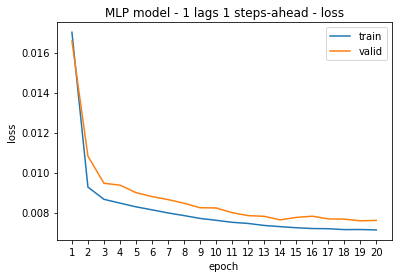

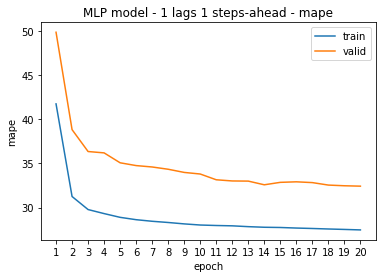

MLP model - 1 lags 1 steps-ahead - train min loss: 0.007133	mae: 0.058966	mape: 27.468418	epoch: 20
MLP model - 1 lags 1 steps-ahead - valid min loss: 0.007589	mae: 0.062022	mape: 32.462051	epoch: 19

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1)              0         
Total params: 6,849
Trainable params: 6,849
Non-trainable pa

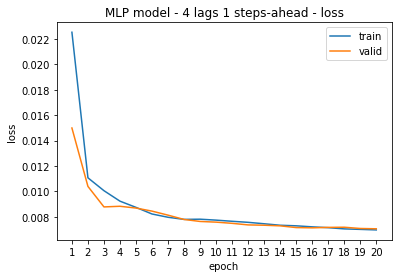

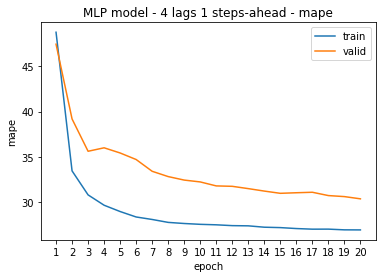

MLP model - 4 lags 1 steps-ahead - train min loss: 0.006956	mae: 0.058290	mape: 26.890669	epoch: 20
MLP model - 4 lags 1 steps-ahead - valid min loss: 0.007045	mae: 0.060080	mape: 30.334518	epoch: 20

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                5184      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 1)              0         
Total params: 9,409
Trainable params: 9,409
Non-trainable pa

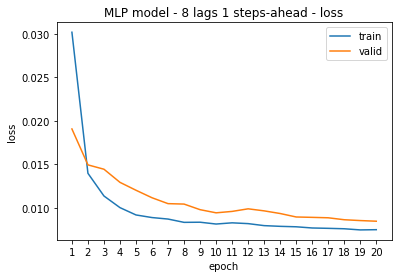

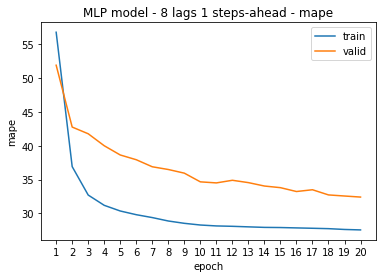

MLP model - 8 lags 1 steps-ahead - train min loss: 0.007473	mae: 0.060104	mape: 27.631851	epoch: 19
MLP model - 8 lags 1 steps-ahead - valid min loss: 0.008474	mae: 0.066659	mape: 32.418095	epoch: 20

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                10304     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 1)              0         
Total params: 14,529
Trainable params: 14,529
Non-trainable 

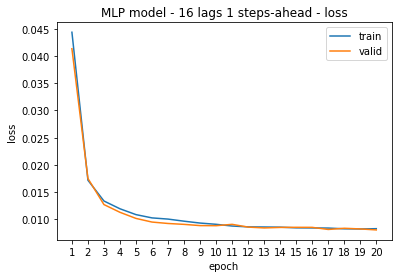

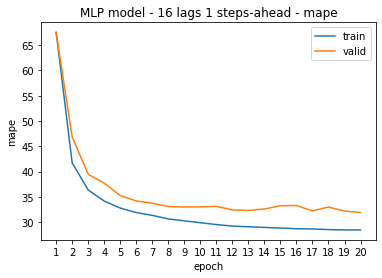

MLP model - 16 lags 1 steps-ahead - train min loss: 0.008204	mae: 0.063457	mape: 28.498030	epoch: 19
MLP model - 16 lags 1 steps-ahead - valid min loss: 0.008031	mae: 0.065657	mape: 31.947010	epoch: 20

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                15424     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
_________________________________________________________________
reshape_6 (Reshape)          (None, 1, 1)              0         
Total params: 19,649
Trainable params: 19,649
Non-trainabl

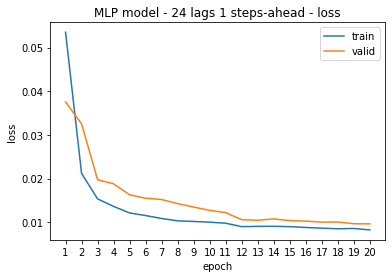

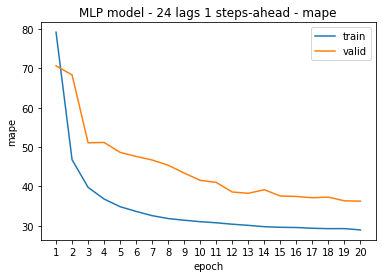

MLP model - 24 lags 1 steps-ahead - train min loss: 0.008217	mae: 0.064210	mape: 28.952085	epoch: 20
MLP model - 24 lags 1 steps-ahead - valid min loss: 0.009597	mae: 0.071899	mape: 36.264130	epoch: 20

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                20544     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
_________________________________________________________________
reshape_7 (Reshape)          (None, 1, 1)              0         
Total params: 24,769
Trainable params: 24,769
Non-trainabl

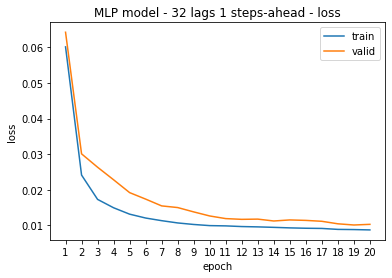

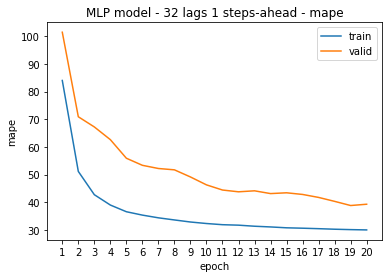

MLP model - 32 lags 1 steps-ahead - train min loss: 0.008758	mae: 0.065852	mape: 30.009214	epoch: 20
MLP model - 32 lags 1 steps-ahead - valid min loss: 0.010138	mae: 0.074604	mape: 38.819370	epoch: 19

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                25664     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
_________________________________________________________________
reshape_8 (Reshape)          (None, 1, 1)              0         
Total params: 29,889
Trainable params: 29,889
Non-trainabl

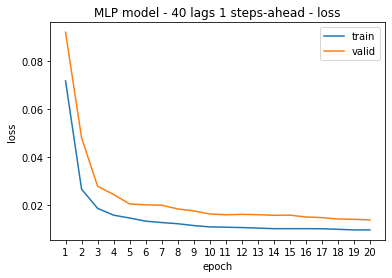

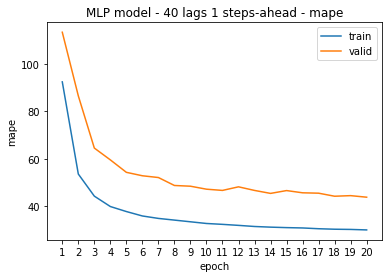

MLP model - 40 lags 1 steps-ahead - train min loss: 0.009494	mae: 0.068646	mape: 30.277441	epoch: 19
MLP model - 40 lags 1 steps-ahead - valid min loss: 0.013679	mae: 0.088259	mape: 43.840256	epoch: 20

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                30784     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
_________________________________________________________________
reshape_9 (Reshape)          (None, 1, 1)              0         
Total params: 35,009
Trainable params: 35,009
Non-trainabl

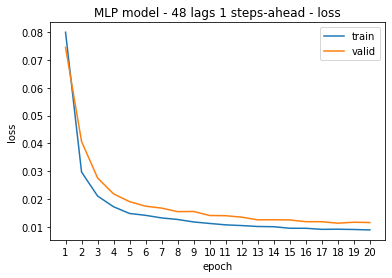

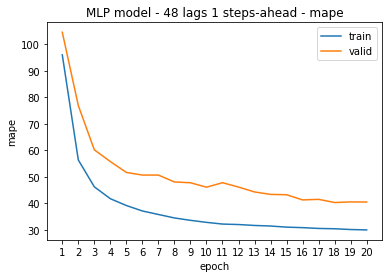

MLP model - 48 lags 1 steps-ahead - train min loss: 0.008852	mae: 0.066772	mape: 29.946476	epoch: 20
MLP model - 48 lags 1 steps-ahead - valid min loss: 0.011277	mae: 0.080371	mape: 40.288456	epoch: 18



In [12]:
def compile_fit_validate(model, train, valid, optimizer, epochs = 5, verbose = 2):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if optimizer.lower() == 'adadelta':
        opt = Adadelta(lr = 1.0)
    else:
        opt = Adam(lr = 0.001)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae', 'mape'])    
    h = model.fit(train, validation_data = valid,
                  epochs = epochs, verbose = verbose)
    
    return h

    
def plot_history(h, name, epochs = 10):
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.xticks(range(0, epochs), labels = range(1, epochs + 1))
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc = 'upper right')
    plt.show()

    plt.plot(h.history['mape'])
    plt.plot(h.history['val_mape'])
    plt.xticks(range(0, epochs), labels = range(1, epochs + 1))
    plt.title(name + ' mape')
    plt.ylabel('mape')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc = 'upper right')
    plt.show();

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mape            = h.history['mape'][argmin_loss]
    val_mape        = h.history['val_mape'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tmape: {4:f}\tepoch: {5:d}"
    print(txt.format(name, "train", min_loss,     mae,     mape,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, val_mape, argmin_val_loss + 1))
    print()


def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


# For testing compile_fit_validate, plot_progress etc
def build_small_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    small = Sequential(name = name)
    
    small.add(Input(shape = in_shape))
    
    small.add(Dense(64, activation = 'relu'))
    small.add(Dense(64, activation = 'relu'))
    
    small.add(Dense(1))    
    
    return small


def build_mlp_model_orig(name, data):
    in_shape, _ = get_io_shapes(data)
    
    mlp = Sequential(name = name)
    
    mlp.add(Input(shape = in_shape))
    mlp.add(Flatten())  # Shape: (time, features) => (time*features)
    mlp.add(Dropout(0.1))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.2))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.2))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.3))
    
    mlp.add(Dense(1))   
    mlp.add(Reshape([1, -1]))
    
    return mlp


def build_mlp_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    mlp = Sequential(name = name)
    
    mlp.add(Input(shape = in_shape))
    mlp.add(Flatten())  # Shape: (time, features) => (time*features)
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(64, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(64, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    # mlp.add(Dense(32, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(1))   
    mlp.add(Reshape([1, -1]))
    
    return mlp


def run_model(model, train, valid, optimizer = 'adam', epochs = 5):
    in_shape, out_shape = get_io_shapes(train)
    model_id = model.name + ' model - ' + str(in_shape[0]) + \
               ' lags ' + str(out_shape[0]) + ' steps-ahead -'
    
    model.summary()
    h = compile_fit_validate(model, train, valid, optimizer, epochs)
    plot_history(h, model_id, epochs)
    print_min_loss(h, model_id)
    
    return h


# lags = 8
# ds_train_8l_1s, ds_valid_8l_1s, ds_test_8l_1s = make_datasets(train_df, valid_df, test_df, 
#                                                              lags = lags, shuffle = False, bs = 8)
 
name = 'MLP'
mlp_1l_1s   = build_mlp_model(name, ds_train_1l_1s)
h_mlp_1l_1s = run_model(mlp_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, optimizer = 'adadelta', epochs = 20)
mlp_4l_1s   = build_mlp_model(name, ds_train_4l_1s)
h_mlp_4l_1s = run_model(mlp_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, optimizer = 'adadelta', epochs = 20)
mlp_8l_1s   = build_mlp_model(name, ds_train_8l_1s)
h_mlp_8l_1s = run_model(mlp_8l_1s, ds_train_8l_1s, ds_valid_8l_1s, optimizer = 'adadelta', epochs = 20)
mlp_16l_1s   = build_mlp_model(name, ds_train_16l_1s)
h_mlp_16l_1s = run_model(mlp_16l_1s, ds_train_16l_1s, ds_valid_16l_1s, optimizer = 'adadelta', epochs = 20)
mlp_24l_1s   = build_mlp_model(name, ds_train_24l_1s)
h_mlp_24l_1s = run_model(mlp_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, optimizer = 'adadelta', epochs = 20)
mlp_32l_1s   = build_mlp_model(name, ds_train_32l_1s)
h_mlp_32l_1s = run_model(mlp_32l_1s, ds_train_32l_1s, ds_valid_32l_1s, optimizer = 'adadelta', epochs = 20)
mlp_40l_1s   = build_mlp_model(name, ds_train_40l_1s)
h_mlp_40l_1s = run_model(mlp_40l_1s, ds_train_40l_1s, ds_valid_40l_1s, optimizer = 'adadelta', epochs = 20)
mlp_48l_1s   = build_mlp_model(name, ds_train_48l_1s)
h_mlp_48l_1s = run_model(mlp_48l_1s, ds_train_48l_1s, ds_valid_48l_1s, optimizer = 'adadelta', epochs = 20)

In [13]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.3
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.4
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.8
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.5
dlib==19.18.0
d

Second, check multiple time-steps.

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 48)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 500)               24500     
_________________________________________________________________
dropout_17 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_18 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 500)               250500  

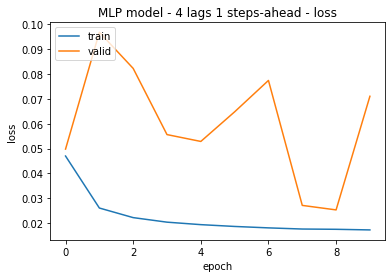

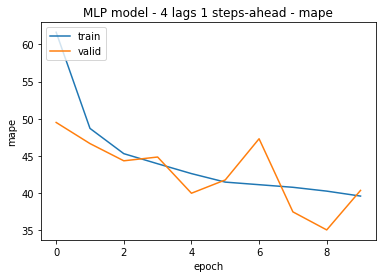

MLP model - 4 lags 1 steps-ahead - train min loss: 0.017309	mae: 0.095741	mape: 39.610294	epoch: 10
MLP model - 4 lags 1 steps-ahead - valid min loss: 0.025352	mae: 0.118178	mape: 35.063484	epoch: 9



In [ ]:
# mlp_4l_4s   = build_mlp_model(name, ds_train_4l_4s)
# h_mlp_4l_4s = run_model(mlp_4l_1s, ds_train_4l_4s, ds_valid_4l_4s, optimizer = 'adadelta', epochs = 50)

# mlp_1l_4s   = build_mlp_model(name, ds_train_1l_4s)
# h_mlp_1l_4s = run_model(mlp_1l_1s, ds_train_1l_4s, ds_valid_1l_4s, optimizer = 'adadelta', epochs = 50)

mlp_4l_1s   = build_mlp_model(name, ds_train_4l_1s)
h_mlp_4l_1s = run_model(mlp_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, optimizer = 'adadelta', epochs = 10)

### Fully convolutional network

See [Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455)
for a detailed description of the Fully Convolutional Network (FCN) architecture.  The FCN
was first described in
[Time-series modeling with undecimated fully convolutional neural networks](https://arxiv.org/abs/1508.00317).

The FCN architecture is a variant of the Convolutional Neural Network (CNN).  A Convolutional 
Neural Network (CNN) usually contains fully-connected layers or a MLP at the 
end of the network.  The FCN does not include these final layers, so it is learning 
convolutional filters everywhere.

**TODO** Include figure comparing FCNs and CNNs

The Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
layer is used for temporal convolution.

First, check single step-ahead predictions.

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             5184      
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 64)             256       
_________________________________________________________________
activation (Activation)      (None, 1, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 128)            41088     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 128)            512       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             24640   

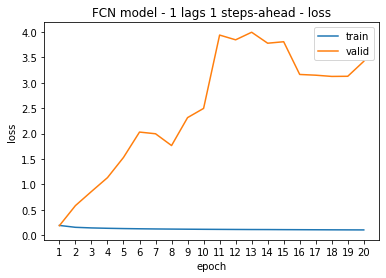

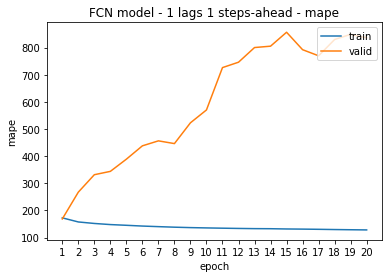

FCN model - 1 lags 1 steps-ahead - train min loss: 0.101301	mae: 0.249617	mape: 128.265656	epoch: 20
FCN model - 1 lags 1 steps-ahead - valid min loss: 0.185704	mae: 0.337062	mape: 168.664429	epoch: 1

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4, 64)             5184      
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 64)             256       
_________________________________________________________________
activation_3 (Activation)    (None, 4, 64)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4, 128)            41088     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 128)            512       
___________________________________________________________

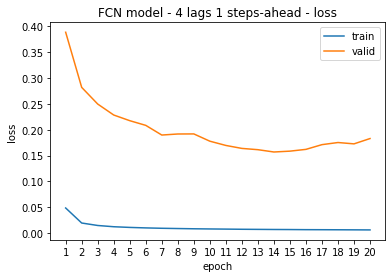

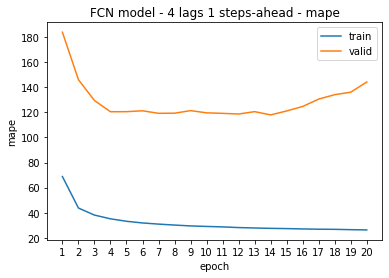

FCN model - 4 lags 1 steps-ahead - train min loss: 0.006293	mae: 0.057556	mape: 26.324949	epoch: 20
FCN model - 4 lags 1 steps-ahead - valid min loss: 0.156902	mae: 0.316000	mape: 117.916344	epoch: 14

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 8, 64)             5184      
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 64)             256       
_________________________________________________________________
activation_6 (Activation)    (None, 8, 64)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 128)            41088     
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 128)            512       
___________________________________________________________

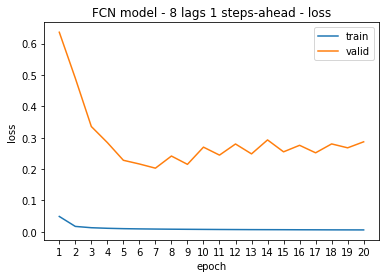

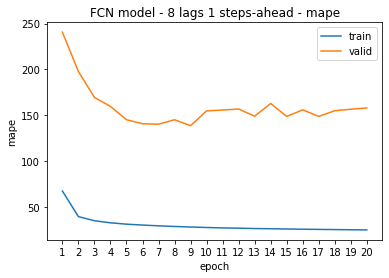

FCN model - 8 lags 1 steps-ahead - train min loss: 0.005686	mae: 0.054639	mape: 24.892933	epoch: 20
FCN model - 8 lags 1 steps-ahead - valid min loss: 0.202676	mae: 0.366459	mape: 140.184845	epoch: 7

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 16, 64)            5184      
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 64)            256       
_________________________________________________________________
activation_9 (Activation)    (None, 16, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 128)           41088     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 128)           512       
____________________________________________________________

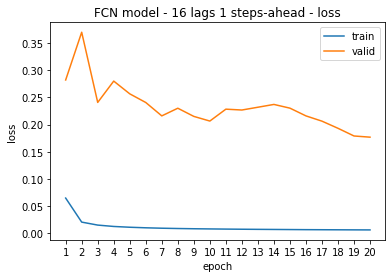

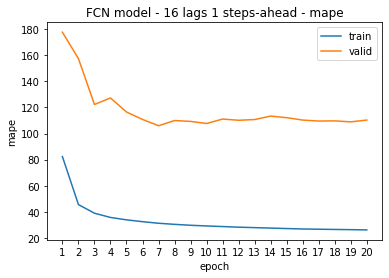

FCN model - 16 lags 1 steps-ahead - train min loss: 0.005935	mae: 0.056311	mape: 26.195065	epoch: 20
FCN model - 16 lags 1 steps-ahead - valid min loss: 0.176696	mae: 0.321675	mape: 110.313156	epoch: 20

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 24, 64)            5184      
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 64)            256       
_________________________________________________________________
activation_12 (Activation)   (None, 24, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 24, 128)           41088     
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 128)           512       
_________________________________________________________

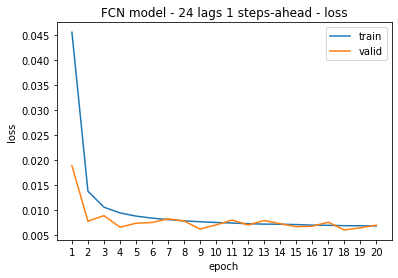

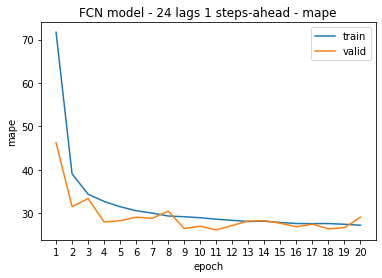

FCN model - 24 lags 1 steps-ahead - train min loss: 0.006886	mae: 0.058478	mape: 27.253826	epoch: 20
FCN model - 24 lags 1 steps-ahead - valid min loss: 0.006083	mae: 0.055534	mape: 26.440973	epoch: 18

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 32, 64)            5184      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 64)            256       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 32, 128)           41088     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 128)           512       
__________________________________________________________

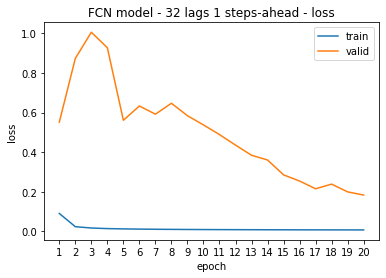

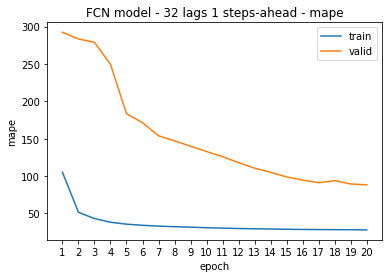

FCN model - 32 lags 1 steps-ahead - train min loss: 0.006857	mae: 0.060392	mape: 27.940985	epoch: 20
FCN model - 32 lags 1 steps-ahead - valid min loss: 0.183108	mae: 0.309936	mape: 88.213760	epoch: 20

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 40, 64)            5184      
_________________________________________________________________
batch_normalization_18 (Batc (None, 40, 64)            256       
_________________________________________________________________
activation_18 (Activation)   (None, 40, 64)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 40, 128)           41088     
_________________________________________________________________
batch_normalization_19 (Batc (None, 40, 128)           512       
__________________________________________________________

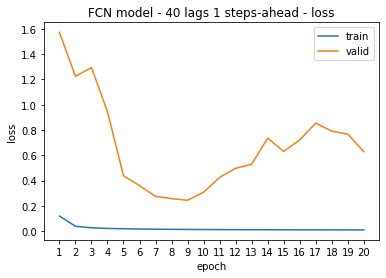

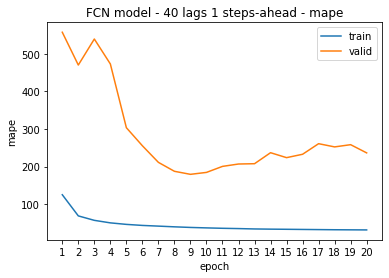

FCN model - 40 lags 1 steps-ahead - train min loss: 0.008832	mae: 0.069574	mape: 31.640919	epoch: 20
FCN model - 40 lags 1 steps-ahead - valid min loss: 0.243426	mae: 0.383329	mape: 179.506485	epoch: 9

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 48, 64)            5184      
_________________________________________________________________
batch_normalization_21 (Batc (None, 48, 64)            256       
_________________________________________________________________
activation_21 (Activation)   (None, 48, 64)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 48, 128)           41088     
_________________________________________________________________
batch_normalization_22 (Batc (None, 48, 128)           512       
__________________________________________________________

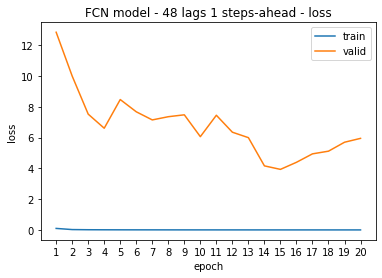

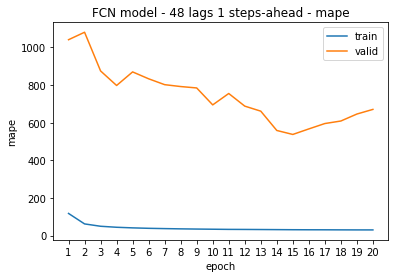

FCN model - 48 lags 1 steps-ahead - train min loss: 0.007930	mae: 0.064919	mape: 29.777382	epoch: 20
FCN model - 48 lags 1 steps-ahead - valid min loss: 3.940141	mae: 1.395491	mape: 537.445740	epoch: 15



In [14]:
def build_fcn_model_orig(name, data):
    in_shape, _ = get_io_shapes(data)
    
    fcn = Sequential(name = name)
    fcn.add(Input(shape = in_shape))
    
    fcn.add(Conv1D(filters = 128, kernel_size = 8, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 128, kernel_size = 3, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(GlobalAveragePooling1D())
    fcn.add(Dense(1))

    return fcn


def build_fcn_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    fcn = Sequential(name = name)
    fcn.add(Input(shape = in_shape))
    
    fcn.add(Conv1D(filters = 64, kernel_size = 8, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 64, kernel_size = 3, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(GlobalAveragePooling1D())
    fcn.add(Dense(1))

    return fcn


lags = 24
ds_train_24l_1s, ds_valid_24l_1s, ds_test_24l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = lags, shuffle = True, bs = 16)

name = 'FCN'
fcn_1l_1s   = build_fcn_model(name, ds_train_1l_1s)
h_fcn_1l_1s = run_model(fcn_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, optimizer = 'adadelta', epochs = 20)
fcn_4l_1s   = build_fcn_model(name, ds_train_4l_1s)
h_fcn_4l_1s = run_model(fcn_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, optimizer = 'adadelta', epochs = 20)
fcn_8l_1s   = build_fcn_model(name, ds_train_8l_1s)
h_fcn_8l_1s = run_model(fcn_8l_1s, ds_train_8l_1s, ds_valid_8l_1s, optimizer = 'adadelta', epochs = 20)
fcn_16l_1s   = build_fcn_model(name, ds_train_16l_1s)
h_fcn_16l_1s = run_model(fcn_16l_1s, ds_train_16l_1s, ds_valid_16l_1s, optimizer = 'adadelta', epochs = 20)
fcn_24l_1s   = build_fcn_model(name, ds_train_24l_1s)
h_fcn_24l_1s = run_model(fcn_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, optimizer = 'adadelta', epochs = 20)
fcn_32l_1s   = build_fcn_model(name, ds_train_32l_1s)
h_fcn_32l_1s = run_model(fcn_32l_1s, ds_train_32l_1s, ds_valid_32l_1s, optimizer = 'adadelta', epochs = 20)
fcn_40l_1s   = build_fcn_model(name, ds_train_40l_1s)
h_fcn_40l_1s = run_model(fcn_40l_1s, ds_train_40l_1s, ds_valid_40l_1s, optimizer = 'adadelta', epochs = 20)
fcn_48l_1s   = build_fcn_model(name, ds_train_48l_1s)
h_fcn_48l_1s = run_model(fcn_48l_1s, ds_train_48l_1s, ds_valid_48l_1s, optimizer = 'adadelta', epochs = 20)

Second, check multiple step-ahead predictions.

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 16, 32)            2592      
_________________________________________________________________
batch_normalization_45 (Batc (None, 16, 32)            128       
_________________________________________________________________
activation_42 (Activation)   (None, 16, 32)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16, 64)            10304     
_________________________________________________________________
batch_normalization_46 (Batc (None, 16, 64)            256       
_________________________________________________________________
activation_43 (Activation)   (None, 16, 64)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16, 32)            6176    

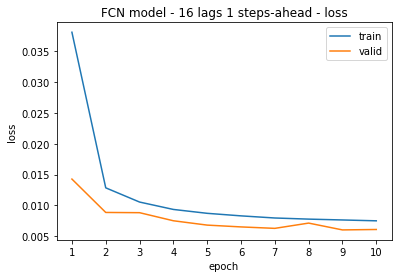

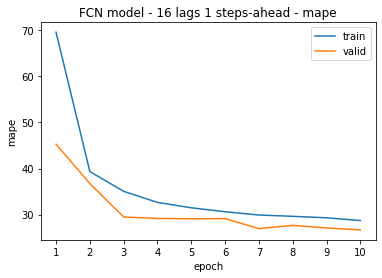

FCN model - 16 lags 1 steps-ahead - train min loss: 0.007498	mae: 0.061582	mape: 28.692619	epoch: 10
FCN model - 16 lags 1 steps-ahead - valid min loss: 0.006021	mae: 0.054550	mape: 27.081793	epoch: 9



In [ ]:
lags = 16
ds_train_16l_1s, ds_valid_16l_1s, ds_test_16l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = lags, shuffle = True, bs = 16)

fcn_16l_1s   = build_fcn_model(name, ds_train_16l_1s)
h_fcn_16l_1s = run_model(fcn_16l_1s, ds_train_16l_1s, ds_valid_16l_1s, epochs = 10)

### Residual network

Residual networks, or ResNets, were originally proposed in
[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

Residual neural networks use "identity shortcut connections" to skip over some layers.  Typical ResNet models are implemented with blocks of layer that contain nonlinearities (ReLU) and batch normalization.
Skipping over layers may avoid the problem of vanishing gradients, by reusing activations from a previous layer until the adjacent layer learns its weights.  This should allow training networks with more layers.

**TODO** Include basic ResNet diagram

Again, the Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
layer is used for temporal convolution.

First, check single step-ahead predictions.

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1, 10)]      0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 1, 64)        5184        input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 1, 64)        256         conv1d_24[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 1, 64)        0           batch_normalization_24[0][0]     
_____________________________________________________________________________________________

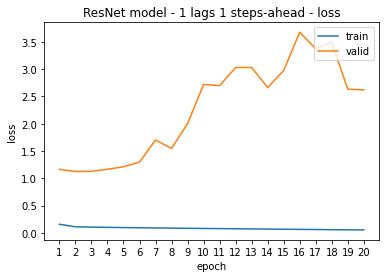

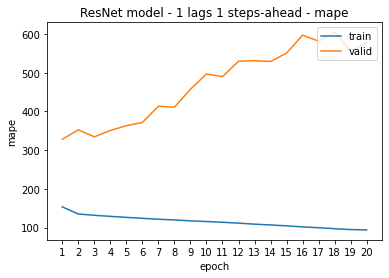

ResNet model - 1 lags 1 steps-ahead - train min loss: 0.055945	mae: 0.183018	mape: 93.874977	epoch: 20
ResNet model - 1 lags 1 steps-ahead - valid min loss: 1.124736	mae: 0.869202	mape: 352.456604	epoch: 2

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 4, 64)        5184        input_20[0][0]                   
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 4, 64)        256         conv1d_35[0][0]                  
____________________________________________________________________________________

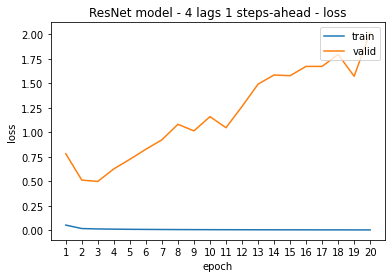

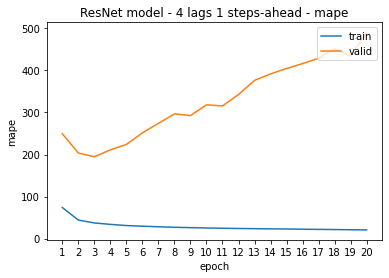

ResNet model - 4 lags 1 steps-ahead - train min loss: 0.004142	mae: 0.046906	mape: 20.667625	epoch: 20
ResNet model - 4 lags 1 steps-ahead - valid min loss: 0.498938	mae: 0.564135	mape: 194.659348	epoch: 3

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 8, 10)]      0                                            
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 8, 64)        5184        input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 8, 64)        256         conv1d_46[0][0]                  
____________________________________________________________________________________

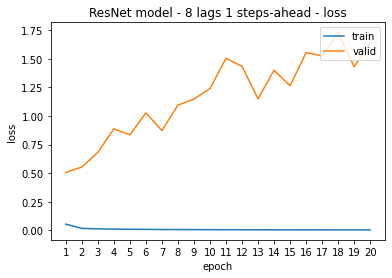

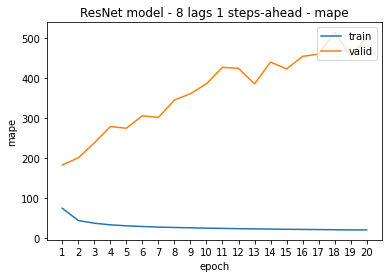

ResNet model - 8 lags 1 steps-ahead - train min loss: 0.004007	mae: 0.046154	mape: 20.101032	epoch: 19
ResNet model - 8 lags 1 steps-ahead - valid min loss: 0.506448	mae: 0.562893	mape: 182.298996	epoch: 1

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 16, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 16, 64)       5184        input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 16, 64)       256         conv1d_57[0][0]                  
____________________________________________________________________________________

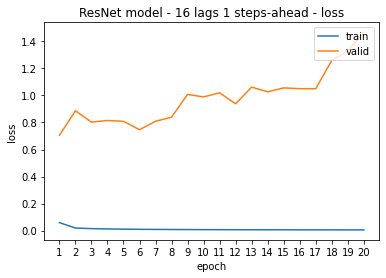

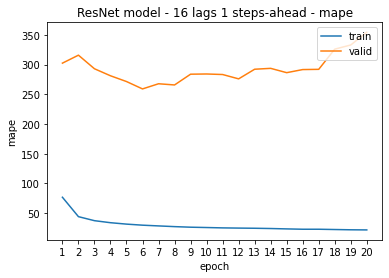

ResNet model - 16 lags 1 steps-ahead - train min loss: 0.004482	mae: 0.048683	mape: 21.740976	epoch: 20
ResNet model - 16 lags 1 steps-ahead - valid min loss: 0.704978	mae: 0.702721	mape: 302.351715	epoch: 1

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 24, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 24, 64)       5184        input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 24, 64)       256         conv1d_68[0][0]                  
__________________________________________________________________________________

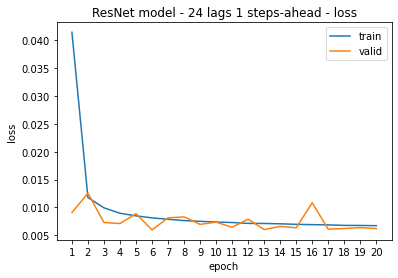

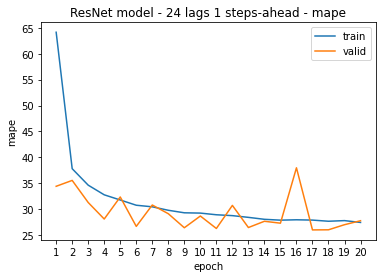

ResNet model - 24 lags 1 steps-ahead - train min loss: 0.006737	mae: 0.057879	mape: 27.432831	epoch: 20
ResNet model - 24 lags 1 steps-ahead - valid min loss: 0.005974	mae: 0.054266	mape: 26.671164	epoch: 6

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_79 (Conv1D)              (None, 32, 64)       5184        input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 32, 64)       256         conv1d_79[0][0]                  
___________________________________________________________________________________

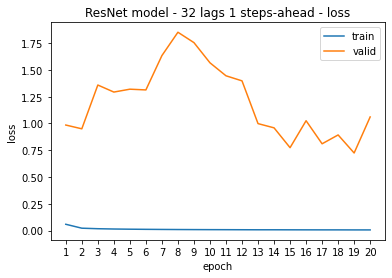

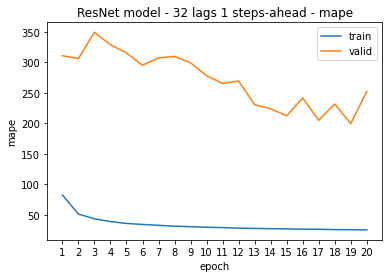

ResNet model - 32 lags 1 steps-ahead - train min loss: 0.006054	mae: 0.057052	mape: 25.452723	epoch: 20
ResNet model - 32 lags 1 steps-ahead - valid min loss: 0.724495	mae: 0.642691	mape: 199.435486	epoch: 19

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 40, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_90 (Conv1D)              (None, 40, 64)       5184        input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 40, 64)       256         conv1d_90[0][0]                  
_________________________________________________________________________________

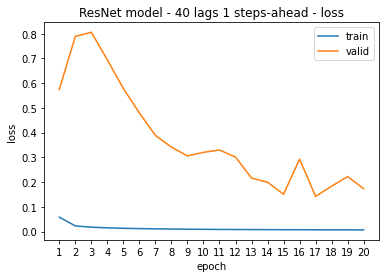

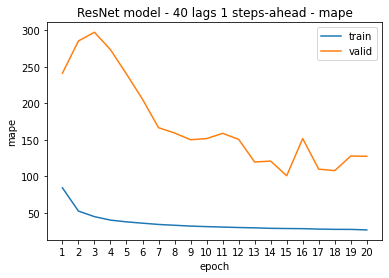

ResNet model - 40 lags 1 steps-ahead - train min loss: 0.006620	mae: 0.059588	mape: 26.527155	epoch: 20
ResNet model - 40 lags 1 steps-ahead - valid min loss: 0.142107	mae: 0.295610	mape: 109.828255	epoch: 17

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 48, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_101 (Conv1D)             (None, 48, 64)       5184        input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 48, 64)       256         conv1d_101[0][0]                 
_________________________________________________________________________________

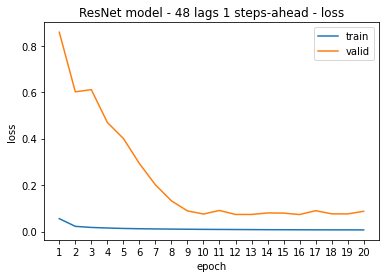

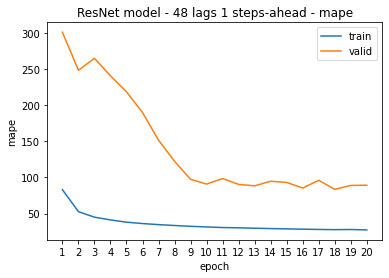

ResNet model - 48 lags 1 steps-ahead - train min loss: 0.007036	mae: 0.061499	mape: 27.453320	epoch: 20
ResNet model - 48 lags 1 steps-ahead - valid min loss: 0.073190	mae: 0.202421	mape: 85.355118	epoch: 16



In [15]:
 def build_resnet_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    n_feature_maps = 64
    
    input_layer = keras.layers.Input(in_shape)
    
    # BLOCK 1
    conv_x = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 8, padding = 'same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 1, padding = 'same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

        
    # BLOCK 2
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 1, padding = 'same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

        
    # BLOCK 3
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    output_layer = keras.layers.Dense(1)(gap_layer)
    resnet = keras.models.Model(name = name, inputs = input_layer, outputs = output_layer)

    return resnet
   

name = 'ResNet'
resnet_1l_1s   = build_resnet_model(name, ds_train_1l_1s)
h_resnet_1l_1s = run_model(resnet_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, optimizer = 'adadelta', epochs = 20)
resnet_4l_1s   = build_resnet_model(name, ds_train_4l_1s)
h_resnet_4l_1s = run_model(resnet_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, optimizer = 'adadelta', epochs = 20)
resnet_8l_1s   = build_resnet_model(name, ds_train_8l_1s)
h_resnet_8l_1s = run_model(resnet_8l_1s, ds_train_8l_1s, ds_valid_8l_1s, optimizer = 'adadelta', epochs = 20)
resnet_16l_1s   = build_resnet_model(name, ds_train_16l_1s)
h_resnet_16l_1s = run_model(resnet_16l_1s, ds_train_16l_1s, ds_valid_16l_1s, optimizer = 'adadelta', epochs = 20)
resnet_24l_1s   = build_resnet_model(name, ds_train_24l_1s)
h_resnet_24l_1s = run_model(resnet_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, optimizer = 'adadelta', epochs = 20)
resnet_32l_1s   = build_resnet_model(name, ds_train_32l_1s)
h_resnet_32l_1s = run_model(resnet_32l_1s, ds_train_32l_1s, ds_valid_32l_1s, optimizer = 'adadelta', epochs = 20)
resnet_40l_1s   = build_resnet_model(name, ds_train_40l_1s)
h_resnet_40l_1s = run_model(resnet_40l_1s, ds_train_40l_1s, ds_valid_40l_1s, optimizer = 'adadelta', epochs = 20)
resnet_48l_1s   = build_resnet_model(name, ds_train_48l_1s)
h_resnet_48l_1s = run_model(resnet_48l_1s, ds_train_48l_1s, ds_valid_48l_1s, optimizer = 'adadelta', epochs = 20)

Second, check multiple step-ahead predictions.

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
conv1d_112 (Conv1D)             (None, 4, 32)        2592        input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 4, 32)        128         conv1d_112[0][0]                 
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 4, 32)        0           batch_normalization_120[0][0]    
_____________________________________________________________________________________________

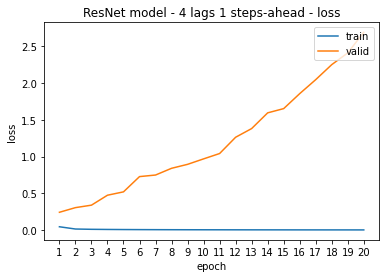

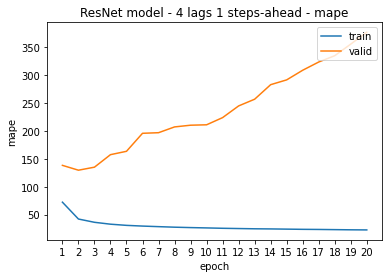

ResNet model - 4 lags 1 steps-ahead - train min loss: 0.004631	mae: 0.049698	mape: 22.528183	epoch: 20
ResNet model - 4 lags 1 steps-ahead - valid min loss: 0.244059	mae: 0.408105	mape: 138.213821	epoch: 1

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 8, 10)]      0                                            
__________________________________________________________________________________________________
conv1d_123 (Conv1D)             (None, 8, 32)        2592        input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_132 (BatchN (None, 8, 32)        128         conv1d_123[0][0]                 
____________________________________________________________________________________

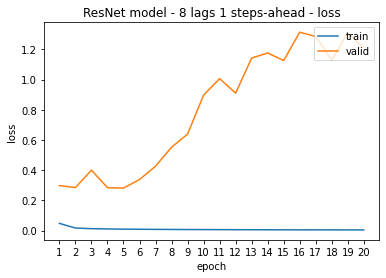

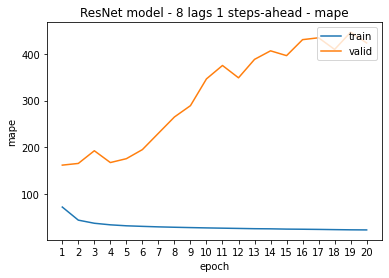

ResNet model - 8 lags 1 steps-ahead - train min loss: 0.004659	mae: 0.049828	mape: 22.112297	epoch: 20
ResNet model - 8 lags 1 steps-ahead - valid min loss: 0.281420	mae: 0.419097	mape: 175.186111	epoch: 5

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 16, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_134 (Conv1D)             (None, 16, 32)       2592        input_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 16, 32)       128         conv1d_134[0][0]                 
____________________________________________________________________________________

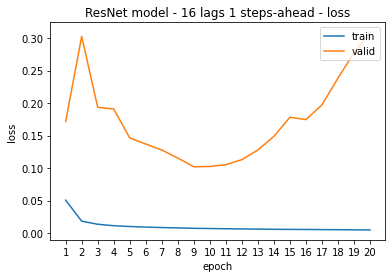

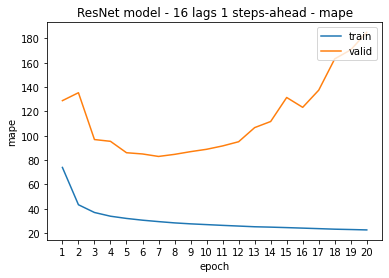

ResNet model - 16 lags 1 steps-ahead - train min loss: 0.004824	mae: 0.050809	mape: 22.667442	epoch: 20
ResNet model - 16 lags 1 steps-ahead - valid min loss: 0.101934	mae: 0.246485	mape: 86.993393	epoch: 9

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 24, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_145 (Conv1D)             (None, 24, 32)       2592        input_30[0][0]                   
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 24, 32)       128         conv1d_145[0][0]                 
___________________________________________________________________________________

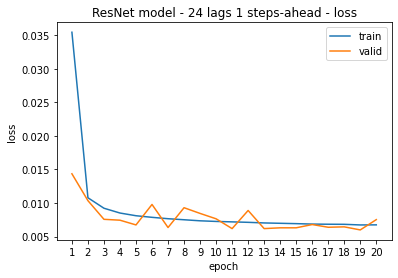

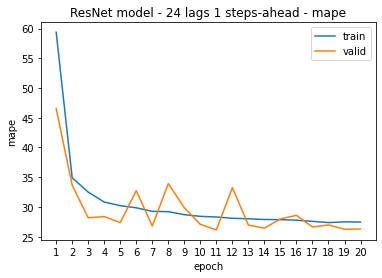

ResNet model - 24 lags 1 steps-ahead - train min loss: 0.006737	mae: 0.057895	mape: 27.496456	epoch: 19
ResNet model - 24 lags 1 steps-ahead - valid min loss: 0.005997	mae: 0.054495	mape: 26.249466	epoch: 19

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 32, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_156 (Conv1D)             (None, 32, 32)       2592        input_31[0][0]                   
__________________________________________________________________________________________________
batch_normalization_168 (BatchN (None, 32, 32)       128         conv1d_156[0][0]                 
__________________________________________________________________________________

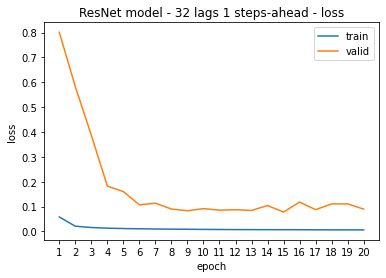

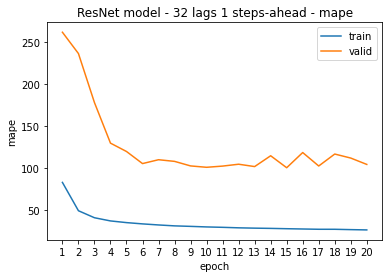

ResNet model - 32 lags 1 steps-ahead - train min loss: 0.006255	mae: 0.057928	mape: 26.289795	epoch: 20
ResNet model - 32 lags 1 steps-ahead - valid min loss: 0.078229	mae: 0.224960	mape: 100.508598	epoch: 15

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 40, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_167 (Conv1D)             (None, 40, 32)       2592        input_32[0][0]                   
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 40, 32)       128         conv1d_167[0][0]                 
_________________________________________________________________________________

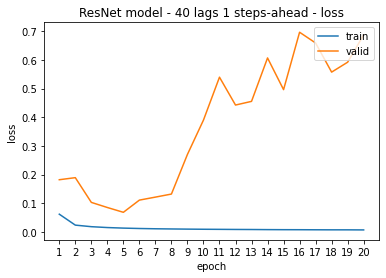

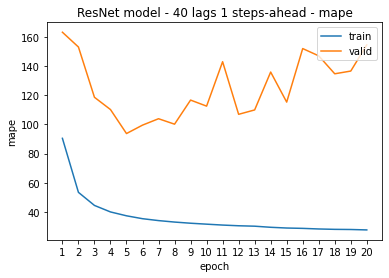

ResNet model - 40 lags 1 steps-ahead - train min loss: 0.006858	mae: 0.060655	mape: 27.697489	epoch: 20
ResNet model - 40 lags 1 steps-ahead - valid min loss: 0.068299	mae: 0.204851	mape: 93.686287	epoch: 5

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 48, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_178 (Conv1D)             (None, 48, 32)       2592        input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_192 (BatchN (None, 48, 32)       128         conv1d_178[0][0]                 
___________________________________________________________________________________

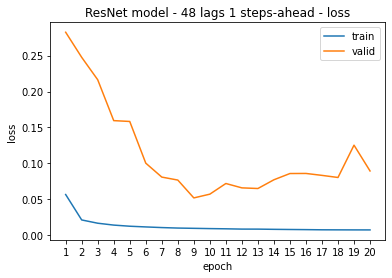

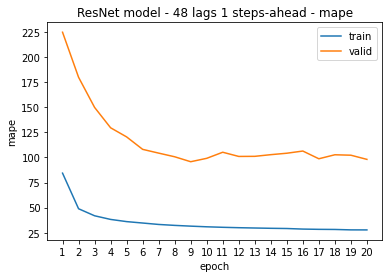

ResNet model - 48 lags 1 steps-ahead - train min loss: 0.007163	mae: 0.061546	mape: 27.838665	epoch: 20
ResNet model - 48 lags 1 steps-ahead - valid min loss: 0.051751	mae: 0.182260	mape: 95.701859	epoch: 9



In [17]:
# resnet_4l_4s   = build_resnet_model(name, ds_train_4l_4s)
# h_resnet_4l_4s = run_model(resnet_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 2)

def build_resnet_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    n_feature_maps = 32
    
    input_layer = keras.layers.Input(in_shape)
    
    # BLOCK 1
    conv_x = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 8, padding = 'same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 1, padding = 'same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

        
    # BLOCK 2
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 1, padding = 'same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

        
    # BLOCK 3
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    output_layer = keras.layers.Dense(1)(gap_layer)
    resnet = keras.models.Model(name = name, inputs = input_layer, outputs = output_layer)

    return resnet
   

name = 'ResNet'
# resnet_1l_1s   = build_resnet_model(name, ds_train_1l_1s)
# h_resnet_1l_1s = run_model(resnet_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, optimizer = 'adadelta', epochs = 20)
resnet_4l_1s   = build_resnet_model(name, ds_train_4l_1s)
h_resnet_4l_1s = run_model(resnet_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, optimizer = 'adadelta', epochs = 20)
resnet_8l_1s   = build_resnet_model(name, ds_train_8l_1s)
h_resnet_8l_1s = run_model(resnet_8l_1s, ds_train_8l_1s, ds_valid_8l_1s, optimizer = 'adadelta', epochs = 20)
resnet_16l_1s   = build_resnet_model(name, ds_train_16l_1s)
h_resnet_16l_1s = run_model(resnet_16l_1s, ds_train_16l_1s, ds_valid_16l_1s, optimizer = 'adadelta', epochs = 20)
resnet_24l_1s   = build_resnet_model(name, ds_train_24l_1s)
h_resnet_24l_1s = run_model(resnet_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, optimizer = 'adadelta', epochs = 20)
resnet_32l_1s   = build_resnet_model(name, ds_train_32l_1s)
h_resnet_32l_1s = run_model(resnet_32l_1s, ds_train_32l_1s, ds_valid_32l_1s, optimizer = 'adadelta', epochs = 20)
resnet_40l_1s   = build_resnet_model(name, ds_train_40l_1s)
h_resnet_40l_1s = run_model(resnet_40l_1s, ds_train_40l_1s, ds_valid_40l_1s, optimizer = 'adadelta', epochs = 20)
resnet_48l_1s   = build_resnet_model(name, ds_train_48l_1s)
h_resnet_48l_1s = run_model(resnet_48l_1s, ds_train_48l_1s, ds_valid_48l_1s, optimizer = 'adadelta', epochs = 20)

### Architecture comparison and/or optimisation

...

Using `ds_test_1s` and `ds_test_4s`.

Plot residuals of optimised model.

Plot some forecasts?

Optimisation with [keras-tuner](https://github.com/keras-team/keras-tuner)?

...

---


## Conclusion

...

Compare with baselines and/or prophet results?

Future work
 * data augmentation/regularisation with a method like [mixup](https://arxiv.org/abs/1710.09412) may be beneficial for the quantised $x$ and $y$ wind vectors
   * mixup may need to be applied between consecutive observations for time series 
 * consider using 2018 data for validation and 2019 for testing
   * check if 2018 & 2019 contain any gaps
 * ...

...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

In [ ]:
!date

---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "keras_mlp_fcn_resnet_time_series.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}